# Symmetric nuclear matter saturation analysis

In this notebook we focus on saturation.

### Python imports, including gsum package and local modules

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
from itertools import product

# Gaussian process kernels are from scikit-learn
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Python plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# gsum provides conjugacy-based implementation of statistical model 
import gsum as gm

# Local modules
from stats_utils import *
from matter import *

### Formatting of figures

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

### Data import and processing

The calculations for infinite matter are stored in a standardized csv file.  Both symmetric nuclear matter (SNM) and pure neutron matter (PNN) are included.  The fields in the file are

  | field | units | description |
  | :---: | :---: | :---- |  
  |  kf   | $$\text{fm}^{-1}$$ | Fermi momentum. |
  |  n    | $$\text{fm}^{-3}$$ | Density. |
  | Kin   |   MeV  | Kinetic energy. |
  | MBPT_HF | MeV  | Hartree-Fock energy (leading order in MBPT). |
  | MBPT_2 |  MeV  | 2nd-order contribution in MBPT (not total). |
  | MBPT_3 |  MeV  | 3rd-order contribution in MBPT (not total). |
  | MBPT_4 |  MeV  | 4th-order contribution in MBPT (not total). |
  | total  |  MeV  | Total energy (sum of all contributions). |
  | Lambda |  MeV  | Regulator parameter.
  | OrderEFT |     | Order of the EFT: LO, NLO, N2LO, N3LO |
  | Body   |       | Two-body only (NN) or two-plus-three (NN+3N)
  |  x     |       | Proton fraction: 0.5 is SNM; 0.0 is PNM. 
  | fit    |       | Index for the fit.



In [3]:
# Read infinite matter data from specified csv file into a dataframe df
df = pd.read_csv('../data/all_matter_data.csv')

# Convert differences to total energy prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)

# 'total' is now unnecessary. Remove it.
df.pop('total');

In [4]:
# Take a look at the contents of the dataframe, for which the MBPT orders
#  are now summed.  So MBPT_4 is the best calculation.
df

,kf,n,Kin,MBPT_HF,MBPT_2,MBPT_3,MBPT_4,Lambda,OrderEFT,Body,x,fit
0,1.13972,0.05,16.16071,10.59411,8.658780,8.674970,8.643290,450,LO,NN-only,0.0,NaN
1,1.21113,0.06,18.24937,11.71829,9.657330,9.760820,9.718110,450,LO,NN-only,0.0,NaN
2,1.27499,0.07,20.22456,12.75249,10.607490,10.787060,10.732550,450,LO,NN-only,0.0,NaN
3,1.33302,0.08,22.10753,13.71538,11.520530,11.763570,11.689420,450,LO,NN-only,0.0,NaN
4,1.38640,0.09,23.91344,14.62031,12.401400,12.698200,12.603940,450,LO,NN-only,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
811,1.36023,0.17,23.01930,2.85390,-14.144875,-15.384495,-14.730505,500,N3LO,NN+3N,0.5,12.0
812,1.38640,0.18,23.91340,3.82840,-14.015855,-15.363205,-14.702775,500,N3LO,NN+3N,0.5,12.0
813,1.41161,0.19,24.79110,4.89930,-13.796182,-15.241912,-14.575082,500,N3LO,NN+3N,0.5,12.0
814,1.43595,0.20,25.65350,6.06520,-13.482510,-15.008020,-14.335640,500,N3LO,NN+3N,0.5,12.0


### Specify the interaction and priors for calculations

In [5]:
# EFT orders LO, NLO, N2LO, N3LO
orders = np.array([0, 2, 3, 4])  # powers of Q
# body = 'NN-only'
# body = 'NN+3N'
# Lambda = 450

# Specify by index what fits will be used for the 3NF [N2LO, N3LO]
#  The indices follow the fits in Fig. 3 of arXiv:1710.08220
fits = {450: [1, 7], 500: [4, 10]}
fits_B = {450: [2, 8], 500: [5, 11]}
fits_C = {450: [3, 9], 500: [6, 12]}

# Specify the training and validation points by defining slice objects
#  slice(start, end, skip) --> slice(2, None, 5) means to start at 2 (3rd in
#   list), then take every 5th one until the end
train = slice(None, None, 2)  # every other one
valid = slice(2, None, 5)

# Don't save figures when plot_saturation or plot_coefficients or 
#  plot_observables are called below
savefigs = False  

Lb = 600

# Number and range of breakdown scales
breakdown_num = 100
breakdown_min = 250
breakdown_max = 1000

Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)  # prior for Lb evaluated on array

ls_min = 0.1
ls_max = 0.7
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None

nugget = 1e-4  # nugget is regulating noise to tame ill-conditioning

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 0.7)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref = 16   # This is the reference scale in MeV

hyperparams = dict(
    center=0,
    disp=0,
    df=1,
    scale=1
)



In [6]:

analyses = []  # accumulate MatterConvergenceAnalysis objects

# Step through body x Lambda (here: only 'NN+3N' for saturation)
#  and extract the relevant quantities from the dataframe  
for body, Lambda in product(['NN+3N'], [450, 500]):  # same as nested for loop
    [fit_n2lo, fit_n3lo] = fits[Lambda]  # fit indices for current Lambda
    
    # Make a mask for the fits
    mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])
    # Mask to select body, fit, and Lambda as specified
    mask = \
        (df['Body'] == body) & \
        mask_fit & \
        (df['Lambda'] == Lambda)

    # Make a new dataframe with masked properties and SNM ('s') only
    df_s = df[mask & (df['x'] == 0.5)]   

    # Create arrays of kf and density values from the LO entries in df_s 
    kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
    density = df_s[df_s['OrderEFT'] == 'LO']['n'].values

    Kf_s = kf_s[:, None]  # 2d version of kf_s array
    # The observables are the MBPT_4 energies at the calculated kf (density)
    #  values for each of the orders. These will be the source of the c_ns.
    y_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values \
                    for order in df_s['OrderEFT'].unique()]).T
    
    # Check the docstring for MatterConvergenceAnalysis for more details
    analysis_s = MatterConvergenceAnalysis(
        X=Kf_s, y=y_s, orders=orders, train=train, valid=valid, ref=ref, 
        ratio='kf', density=density,
        kernel=kernel, system='symmetric', 
        fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=body, savefigs=savefigs, **hyperparams
    )
    
    # logprior=None means a flat prior is used.
    analysis_s.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, 
        breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=[2, 3], logprior=None
    )
    analyses.append(analysis_s)

Using breakdown = 318.1818181818182 MeV
x_min: 1.3600716816816816, y_min: -15.506128048577795
Using breakdown = 318.1818181818182 MeV
x_min: 1.3600716816816816, y_min: -14.715861245865492
Using breakdown = 295.45454545454544 MeV
x_min: 1.3600716816816816, y_min: -13.958225330037873
Using breakdown = 295.45454545454544 MeV
x_min: 1.3600716816816816, y_min: -14.138929192004577
[1.32 1.34 1.36 1.38]
[1.32 1.34 1.36 1.38]


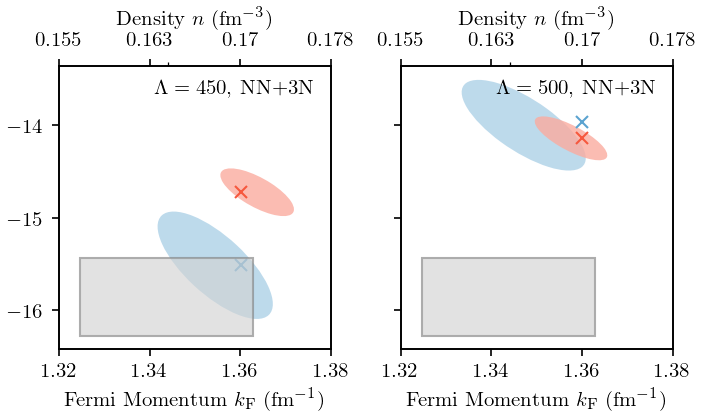

In [7]:
# Kf_interp = Kf_s
Kf_interp = np.linspace(kf_s.min(), kf_s.max(), 100)[:, None]

fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True)
for i, analysis in enumerate(analyses):
    ax = axes.ravel()[i]
    analysis.plot_saturation(breakdown=None, order=3, nugget=1e-6, 
                             X=Kf_interp, ax=ax, alpha=0.8)
    analysis.plot_saturation(breakdown=None, order=4, nugget=1e-6, 
                             X=Kf_interp, ax=ax, alpha=0.8)
    ax.text(0.35, 0.9, s=rf'$\Lambda={analysis.Lambda}$, {analysis.body}', 
            transform=ax.transAxes)

fig.tight_layout()

# Step through the MatterConvergenceAnalysis objects
for ax, analysis in zip(axes, analyses):
    kf_ticks = ax.get_xticks()
    print(kf_ticks)
    ax.set_xticks(kf_ticks)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    d_ticks = analysis.compute_density(kf_ticks)
    ax2.set_xticks(kf_ticks)
    ax2.set_xticklabels([f'{dd:0.3}' for dd in d_ticks])
    ax2.set_xticks([analysis.compute_momentum(0.164)], minor=True)
    ax2.set_xlabel(r'Density $n$ (fm$^{-3}$)')
fig.tight_layout()

fig.savefig('new_figures/coester_ellipses')

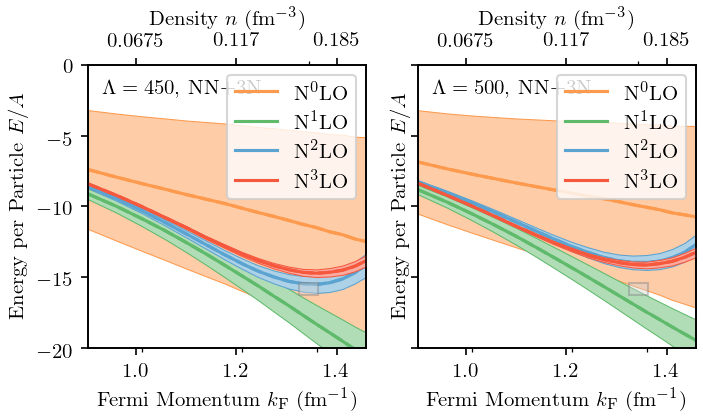

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=True)
for i, analysis in enumerate(analyses):
    ax = axes.ravel()[i]
    analysis.plot_observables(breakdown=None, show_process=True, ax=ax)
    ax.text(0.05, 0.9, s=rf'$\Lambda={analysis.Lambda}$, {analysis.body}', 
            transform=ax.transAxes)
    ax.set_ylim(-20, 0)
fig.tight_layout()
fig.savefig('new_figures/sym-obs-3N-with-empirical')

Using breakdown = 318.1818181818182 MeV
Using breakdown = 295.45454545454544 MeV


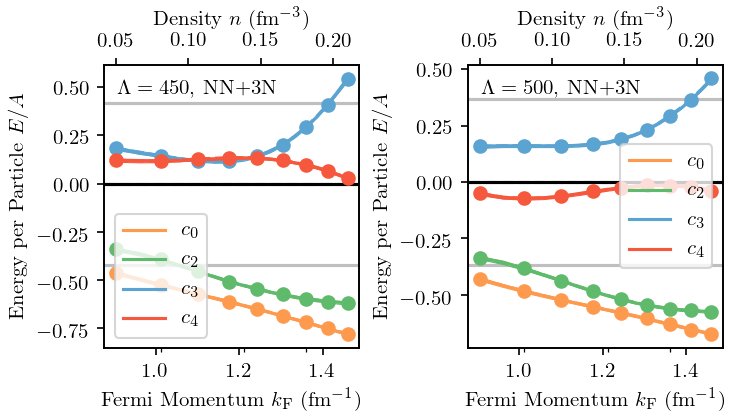

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=False)
for i, analysis in enumerate(analyses):
    ax = axes.ravel()[i]
    analysis.plot_coefficients(breakdown=None, show_process=True, ax=ax)
    ax.text(0.05, 0.9, s=rf'$\Lambda={analysis.Lambda}$, {analysis.body}', 
            transform=ax.transAxes)
fig.tight_layout()